In [9]:
import numpy as np
import tensorflow as tf
from global_config import logger, cfg
from Classes.Models import get_model
import os
import math
from obspy import Trace, Stream, UTCDateTime
from Classes.Scaler import Scaler
from Classes.Utils import one_prediction
from seismonpy.core import SeismonStream
from seismonpy.norsardb import Client
from seismonpy.utils import convert_velocity_slowness, create_global_mongodb_object
from seismonpy.array_analysis.beams import array_beam
from seismonpy.auto.beams.beam_types import VerticalCoherentBeamRecipe, HorizontalCoherentBeamRecipe
from seismonpy.io.mongodb.eventdb import MongoEventDataBase
import warnings
import matplotlib.pyplot as plt



from PIL import Image
from tqdm import tqdm
from datetime import datetime


In [12]:
class ClassifyGBF:

    def __init__(self):
        warnings.simplefilter(action='ignore', category=UserWarning)

    def get_beam(self, start, end, picks, inventory):
        p_vel = cfg.live.p_vel
        s_vel = cfg.live.s_vel
        edge = cfg.live.edge
        startt = start - edge
        endt = end + edge
        baz = self.average_bazimuth(picks)
        try:
            comp = 'BH*'
            zcomp = '*Z'
            tcomp = '*T'
            rcomp = '*R'
            if start < UTCDateTime('2014-09-19T00:00:00'):
                comp = 's*'
                zcomp = '*z'

            stream = Client().get_waveforms(
                'AR*', comp, starttime=startt - edge, endtime=endt + edge, sampling_rate_tolerance=0.5
            )

            stream = self.correct_trace_start_times(stream)

            # Check for masked data, NaN values in traces
            # Remove traces with more than 5 s masked
            masked_traces = []
            for tr in stream.traces:
                if isinstance(tr.data, np.ma.masked_array):
                    time_filled = tr.stats.delta* np.sum(tr.data.mask)
                    if time_filled > 5.0:
                        print(f'{time_filled:.4f} s of trace data masked, dropping trace - {tr.stats.starttime.__str__()}')
                        masked_traces.append(tr)
                    else:
                        tr.data = tr.data.filled(0.0)
                        print(f'{time_filled:.4f} s of trace data masked, filling with zeros - {tr.stats.starttime.__str__()}')

                num_nans = np.sum(np.isnan(tr.data))
                if num_nans > 0:
                    time_containing_nans = num_nans*tr.stats.delta
                    if time_containing_nans > 5.0:
                        print(f'{time_containing_nans:.4f} s of trace has NaNs, dropping trace - {tr.stats.starttime.__str__()}')
                        masked_traces.append(tr)
                    else:
                        tr.data = np.nan_to_num(tr.data)
                        print(f'{time_containing_nans:.4f} s of trace has NaNs, filling with zeros - {tr.stats.starttime.__str__()}')


            for tr in masked_traces:
                if tr in stream.traces: # May have been removed already
                    stream.remove(tr)
            
            if len(stream) == 0:
                raise RuntimeError('Stream has no remaining traces')

            stream.detrend('demean')
            stream.taper(max_percentage=None, max_length=edge, type='cosine', halfcosine=True)
            stream.filter('highpass', freq=1.5)
            stream.resample(cfg.live.sample_rate)
            #print("SAMPLE RATE:", cfg.live.sample_rate)
            stream.rotate('NE->RT', back_azimuth=baz, inventory=inventory)

            p_time_delays = inventory.beam_time_delays(baz, p_vel)
            p_beam_z = stream.select(channel=zcomp).create_beam(p_time_delays)
            p_beam_z.stats.channel = 'P-beam, Z'

            s_time_delays = inventory.beam_time_delays(baz, s_vel)
            s_beam_t = stream.select(channel=tcomp).create_beam(s_time_delays)
            s_beam_t.stats.channel = 'S-beam, T'
            s_beam_r = stream.select(channel=rcomp).create_beam(s_time_delays)
            s_beam_r.stats.channel = 'S-beam, R'

            p_beam_z.trim(start, end)
            s_beam_t.trim(start, end)
            s_beam_r.trim(start, end)
            
            filter_name = cfg.filters.highpass_or_bandpass
            if filter_name == "highpass":
                stream.filter('highpass', freq = cfg.filters.high_kwargs.high_freq)
            if filter_name == "bandpass":
                stream.filter('bandpass', freqmin=cfg.filters.band_kwargs.min, freqmax=cfg.filters.band_kwargs.max)

            stream = Stream([p_beam_z, s_beam_t, s_beam_r])
            tracedata = np.array([p_beam_z.data, s_beam_t.data, s_beam_r.data])

            return tracedata, stream

        except Exception as exc:
            print('ERROR: {} - {}'.format(start, exc))
            return str(type(exc)) + str(exc), None

    def correct_trace_start_times(self, stream, max_delta=0.15):
        """
        For old data the traces might have tiny offset in start time, which breaks
        beamforming. Adjust this manually.
        Remove traces with diff > max_delta
        """
        sts = [tr.stats.starttime for tr in stream.traces]
        most_common = np.unique(sts)[0]

        for tr in stream.traces:
            this_starttime = tr.stats.starttime
            if this_starttime != most_common:
                if abs(this_starttime - most_common) <= max_delta:
                    tr.stats.starttime = most_common
                else:
                    print('Removing trace:', tr)
                    stream.remove(tr)
        
        return stream
    
    def get_data_to_predict(self, starttime, endtime):
        filtered_events, inventory = self.get_array_picks(starttime, endtime, cfg.live.array)
        print("Number of filtered events: ", len(filtered_events))
        print(f"Inventory: {inventory}")
        starttimes, endtimes = self.transform_events_to_start_and_end_times(filtered_events)
        print(f"starttimes: {starttimes}")
        tracedata, streams = [], []
        for i, (starttime, endtime) in enumerate(zip(starttimes, endtimes)):
            traced, stream = self.get_beam(starttime, endtime, filtered_events[i], inventory)
            if traced is not isinstance(traced, str):
                tracedata.append(traced)
                streams.append(stream)
        return tracedata, streams, starttimes, endtimes

    
    def average_bazimuth(self, picks):
        bazimuths = [pick['backazimuth'] for pick in picks]
        # Convert each azimuth to radians
        radian_bazimuths = [math.radians(az) for az in bazimuths]
        
        # Calculate mean of sin and cos
        mean_sin = sum(math.sin(az) for az in radian_bazimuths) / len(radian_bazimuths)
        mean_cos = sum(math.cos(az) for az in radian_bazimuths) / len(radian_bazimuths)
        
        # Use atan2 to compute average azimuth in radians
        average_bazimuth_rad = math.atan2(mean_sin, mean_cos)
        
        # Convert back to degrees, ensuring the result is within [0, 360)
        average_bazimuth_deg = math.degrees(average_bazimuth_rad) % 360
        
        return average_bazimuth_deg
    
    def predict_gbf_event(self):
        # Wrapper for predict function that handles GBF picks.
        raise NotImplementedError
    
    def load_events(self, starttime: UTCDateTime, endtime: UTCDateTime, collection: str = "gbf1440_large", dbname: str = "auto",  
        mongourl: str = "mongo.norsar.no:27017", mongodb_user: str = "guest", mongodb_password: str = "guest", 
        mongodb_authsource: str = "test"):
        query = {"$and":
            [
                {"origins.time": {"$gt": starttime.isoformat()}},
                {"origins.time": {"$lt": endtime.isoformat()}},
                {"picks.waveform_id.station_code": "ARCES"}
            ]
            }
        obj = create_global_mongodb_object(mongourl.split(":")[0], int(mongourl.split(":")[1]), mongodb_user, mongodb_password, mongodb_authsource)
        db = MongoEventDataBase(obj[dbname], collection)
        events = db.find_events(query, decode_result=True)
        inventory = Client().get_array_inventory(cfg.live.array)
        return events, inventory

    def get_array_picks(self, starttime: UTCDateTime, endtime:UTCDateTime, station_code: str):
        events, inventory = self.load_events(starttime, endtime)
        # Filter events where ARCES made a detection
        relevant_events = [event for event in events if any(pick.waveform_id.station_code == station_code for pick in event.picks)]
        
        # Extract only the ARCES-related picks from those events
        nested_filtered_events = []
        for event in relevant_events:
            arces_picks = [pick for pick in event.picks if pick.waveform_id.station_code == station_code]
            nested_filtered_events.append(arces_picks)
            
        return nested_filtered_events, inventory

    def transform_events_to_start_and_end_times(self, filtered_events: list):
        starttimes, endtimes = [], []
        for event in filtered_events:
            pick_times = [pick.time for pick in event]
            start = min(pick_times)
            end = max(pick_times)
            duration = end - start
            # Need to make sure the event is long enough to include the entire event + event buffer. 
            # Also 
            if duration < cfg.live.length:
                missing_length = cfg.live.length - duration
                start = start - missing_length/2
                end = end + missing_length/2
            # How to handle events that are too long for the model? 
            starttimes.append(start - cfg.live.event_buffer)
            endtimes.append(end + cfg.live.event_buffer)

        return starttimes, endtimes
    
class LiveClassifier:
    def __init__(self, model, scaler, label_maps, cfg):
        self.cfg = cfg
        self.model = model
        self.label_maps = label_maps
        self.scaler = scaler

    def predict(self, trace):
        """
        Performs event classification for a specified time range.
        Args:
            start (UTCDateTime): Start time of the time range.
            end (UTCDateTime): End time of the time range.
            step (float): Step size in seconds.
        Returns:
            Predicted class.
        """
        print("trace shape pre t: ", trace.shape)
        trace = trace.T
        print("trace shape post t: ", trace.shape)
        X = self.prepare_multiple_intervals(trace)
        for x in X:
            print("x shape: ", x.shape)
        X = [self.local_minmax(x) for x in X]
        X = np.array(X)
        # TODO: Figure out the logic for this
        yhats, yprobas, final_yhat, mean_proba = self.ensamble_predict(self.model, X)

        return final_yhat, mean_proba, yhats, yprobas, X
    
    def prepare_multiple_intervals(self, trace):
        traces = []
        # Creates equally sized intervals of the trace, using the user defined step size.
        for start in range(0, len(trace) - (cfg.live.length*cfg.live.sample_rate)+1, (cfg.live.step*cfg.live.sample_rate)+1):
            traces.append(trace[start:(start+cfg.live.length*cfg.live.sample_rate)+1])
        return traces

    def ensamble_predict(self, model, X):
        # Basic ensamble prediction for the input data.
        # TODO: Consider weighing predictions higher around the center (assuming thats where the pick is).
        yhats, probas = [], {"detector": [], "classifier": []}
        for x in X:
            yhat, proba = one_prediction(model, x, self.label_maps)
            yhats.append(yhat)
            probas["detector"].append(proba["detector"])
            probas["classifier"].append(proba["classifier"])
        unqiue, counts = np.unique(yhats, return_counts=True)
        final_yhat = unqiue[np.argmax(counts)]
        mean_proba = {"detector": np.mean(probas["detector"], axis=0), "classifier": np.mean(probas["classifier"], axis=0)}
        return yhats, probas, final_yhat, mean_proba
    
    def local_minmax(self, trace):
        mmax = np.max(trace)
        mmin = np.min(trace)
        return (trace - mmin) / (mmax - mmin)
    
    def plot_predicted_event(self, intervals, event_time, yprobas, yhats, final_yhat):
        # Initialize the list to store frames
        frames = []
        
        # Loop through time intervals
        for i, interval in enumerate(intervals):
            
            # Create a figure for the plots
            fig, axs = plt.subplots(4, 1, figsize=(10, 8))
            
            # Convert numpy array to ObsPy Stream for plotting
            stream = Stream()
            
            for i, interval in enumerate(intervals):
            fig, axs = plt.subplots(4, 1, figsize=(10, 8))

            channel_names = ['P-beam, Z', 'S-beam, T', 'S-beam, R']

            for j in range(3):
                tr = Trace()
                tr.data = interval[:, j]
                tr.stats.network = cfg.live.array
                tr.stats.station = "TBD"
                tr.stats.channel = channel_names[j]
                tr.plot(type='dayplot', fig=fig, handle=True, axes=axs[j])  # Plot each trace individually

            
            # Plot the traces using ObsPy
            #stream.plot(type='dayplot', fig=fig, handle=True, axes=axs[:3])
            
            # Plot the model predictions
            axs[3].plot(yprobas['detector'][:i+1], label='Detector', color='r')
            axs[3].plot(yprobas['classifier'][:i+1], label='Classifier', color='b')
            axs[3].set_ylim([0, 1])
            axs[3].set_title('Model Predictions')
            axs[3].legend()
            
            # Capture the current frame
            fig.canvas.draw()
            image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
            image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
            frames.append(image)
            
            # Close the figure to free memory
            plt.close(fig)
        
        # Generate GIF
        imageio.mimsave(os.path.join(cfg.paths.live_test_path, f'{event_time}_{final_yhat}.gif'), frames, fps=1)

        


In [13]:
detector_label_map = {0: "noise", 1: "event"}
classifier_label_map = {0:"earthquake", 1:"exlposion"}
label_maps = {"detector": detector_label_map, "classifier": classifier_label_map}


input_shape = (cfg.live.length*cfg.live.sample_rate + 1, 3)
detector_class_weight_dict = {"noise": 1, "event": 1}
classifier_class_weight_dict = {"earthquake": 1, "explosion": 1}

logger.info("Input shape to the model: " + str(input_shape))
classifier_metrics = [None]
detector_metrics = [None]
model = get_model(detector_label_map, classifier_label_map, detector_metrics, classifier_metrics, 
                   detector_class_weight_dict, classifier_class_weight_dict)
model.build(input_shape=(None, *input_shape))  # Explicitly building the model here
model.load_weights(os.path.join(cfg.paths.model_save_folder, cfg.model_name))
logger.info(f"Loaded model weights from {os.path.join(cfg.paths.model_save_folder, cfg.model_name)}")

classify = ClassifyGBF()

starttime = UTCDateTime('2023-09-30T14:01:00')
endtime =   UTCDateTime('2023-09-30T16:45:00')
tracedata, streams, starttimes, endtimes = classify.get_data_to_predict(starttime, endtime)

ARCES - 1128696887.py:10 - <module> - INFO: Input shape to the model: (9601, 3)
ARCES - 1128696887.py:17 - <module> - INFO: Loaded model weights from /staff/tord/Workspace/arces_classification/output/models/cnn_dense_ancient-lake-7231_20231013_100052_model_weights.h5
Number of filtered events:  15
Inventory: Inventory created at 2023-10-30T11:13:08.004540Z
	Created by: ObsPy 1.4.0
		    https://www.obspy.org
	Sending institution: NO
	Contains:
		Networks (1):
			NO
		Stations (26):
			NO.ARA0 ()
			NO.ARA1 ()
			NO.ARA2 ()
			NO.ARA3 ()
			NO.ARB1 ()
			NO.ARB2 ()
			NO.ARB3 ()
			NO.ARB4 ()
			NO.ARB5 ()
			NO.ARC1 ()
			NO.ARC2 ()
			NO.ARC3 ()
			NO.ARC4 ()
			NO.ARC5 ()
			NO.ARC6 ()
			NO.ARC7 ()
			NO.ARD1 ()
			NO.ARD2 ()
			NO.ARD3 ()
			NO.ARD4 ()
			NO.ARD5 ()
			NO.ARD6 ()
			NO.ARD7 ()
			NO.ARD8 ()
			NO.ARD9 ()
			NO.ARE0 ()
		Channels (280):
			NO.ARA0..BDF, NO.ARA0..BHZ, NO.ARA0..BHN, NO.ARA0..BHE, 
			NO.ARA0..HHZ, NO.ARA0..HHN, NO.ARA0..HHE, NO.ARA0.SE.SHE (3x), 
			N

3
[UTCDateTime(2023, 9, 30, 14, 23, 23, 600000), UTCDateTime(2023, 9, 30, 14, 28, 5, 450000), UTCDateTime(2023, 9, 30, 14, 27, 18, 600000), UTCDateTime(2023, 9, 30, 14, 48, 45, 750000), UTCDateTime(2023, 9, 30, 14, 56, 55, 650000), UTCDateTime(2023, 9, 30, 14, 55, 37, 250000), UTCDateTime(2023, 9, 30, 15, 11, 36, 950000), UTCDateTime(2023, 9, 30, 15, 16, 33), UTCDateTime(2023, 9, 30, 15, 33, 4, 200000), UTCDateTime(2023, 9, 30, 15, 46, 13, 750000), UTCDateTime(2023, 9, 30, 15, 58, 39), UTCDateTime(2023, 9, 30, 16, 8, 22, 100000), UTCDateTime(2023, 9, 30, 16, 14, 11, 500000), UTCDateTime(2023, 9, 30, 16, 11, 57, 750000), UTCDateTime(2023, 9, 30, 16, 25, 48, 200000)]
trace shape pre t:  (3, 12001)
trace shape post t:  (12001, 3)
x shape:  (9601, 3)
x shape:  (9601, 3)
x shape:  (9601, 3)
x shape:  (9601, 3)
x shape:  (9601, 3)
x shape:  (9601, 3)
1/1 [==============================] - 0s 34ms/step


ValueError: All traces need to be of the same id for a dayplot

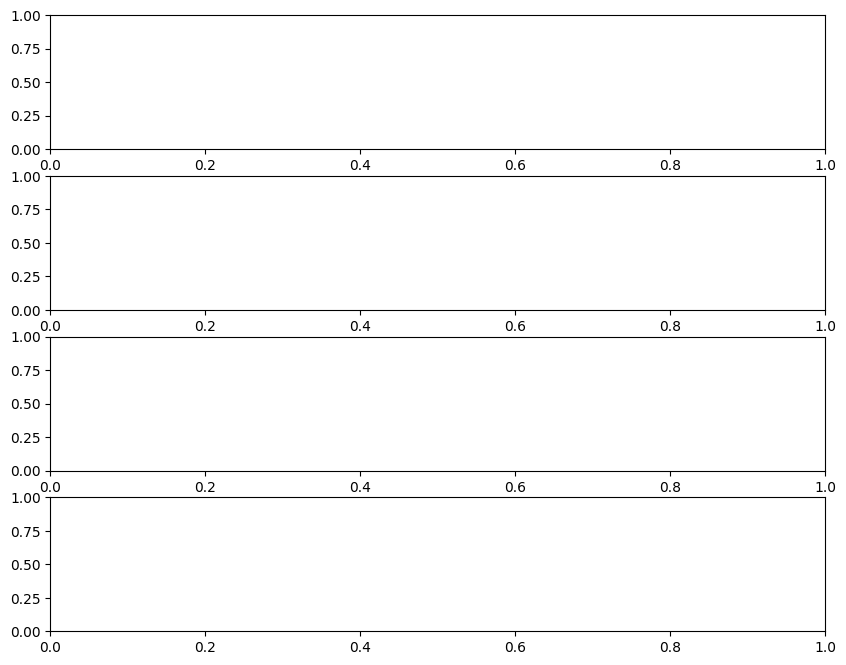

In [14]:
print(len(tracedata[0]))
model = LiveClassifier(model, Scaler(), label_maps, cfg)
final_classifications = []
mean_probas = []
print(starttimes)
for idx, trace in enumerate(tracedata):
    final_yhat, mean_proba, yhats, yprobas, intervals = model.predict(trace)
    final_classifications.append(final_yhat)
    mean_probas.append(mean_proba)
    model.plot_predicted_event(intervals, starttimes[idx], yprobas, yhats, final_yhat)

print("All classifications:", final_classifications)
print("Mean probas:", mean_probas)

In [5]:
preds

NameError: name 'preds' is not defined